In [1]:
import os
import pandas as pd
import numpy as np
import h5py
from collections import Counter

import pandas as pd

def read_info_from_predixcan(fn, id2gene = None):
    ## inputs:
    ## fn: path to the file outputed from the S-Predixcan
    ## id2gene: an list or array of ensembl ids to order the output vector if provided
    ##          otherwise the output array is arranged as it is in the S-Predixcan file
    
    df_meta = pd.read_csv(fn)
    df_meta = df_meta.dropna(axis = 0)
    if id2gene == None:
        id2gene = list(df_meta.index)
    
    gene2zscore = {item.gene:item.zscore for item in df_meta.itertuples()}
    gene2var = {item.gene:item.VAR_g for item in df_meta.itertuples()}

    var_g = np.zeros(len(id2gene))
    for i, g in enumerate(id2gene):
        if g in gene2var:
            var_g[i] = gene2var[g]

    z_g = np.zeros(len(id2gene))
    for i, g in enumerate(id2gene):
        if g in gene2zscore:
            z_g[i] = gene2zscore[g]
    
    return z_g, var_g
                
def compute_gwas_z(pca_genes, pca_weight, pca_sig, gene2zscore, gene2var):
    ## inputs:
    ## df_spca: a (lantent factor, gene) numpy array of the lantent factor x gene matrix
    ## sig_gtex: a (gene, ) numpy array of the per-gene variance from GTEX
    ## df_cov: a (gene, gene) numpy array of the gene-gene covariance
    ## z_g: a (gene, ) numpy array of per-gene GWAS associations from s-predixscan
    ## var_g: a (gene, ) numpy array of per-gene GWAS variance from s-predixscan
    ## is_deconvolute: a bool variable. If True the the deconvolution is performed.
    
    
    z_lantent = 0.0
    for i, g in enumerate(pca_genes):
        if g in gene2zscore and g in gene2var:
            w = pca_weight[i]
            z = gene2zscore[g]
            s = np.sqrt(gene2var[g])
            
            z_lantent += w*z*s
    z_lantent = z_lantent / pca_sig
    #print c, c / np.sqrt(pca_weight.dot(df_1k[pca_genes].cov().values).dot(pca_weight))
    '''
    z_g = np.zeros(*pca_weight.shape)
    sig_g = np.zeros(*pca_weight.shape)
    for i, g in enumerate(pca_genes):
        if g in gene2zscore and g in gene2var:
            z_g[i] = gene2zscore[g]
            sig_g[i] = np.sqrt(gene2var[g])
            
    z_lantent = np.sum(pca_weight * (z_g * sig_g)) / pca_sig
    '''
    return z_lantent

In [2]:
fns = sorted(os.listdir('../processed_data/adj_expression/'))

In [3]:
tissue = fns[0].split('-')[0]

In [4]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)
    
with open('../processed_data/selected_phenotypes.txt', 'rb') as reader:
    id2ph = [i.strip() for i in reader.readlines()] 


In [5]:
#!/usr/bin/env python
import pandas
import sqlite3

connection = sqlite3.connect("../data/gwas_g2p/metaxcan_results_p/metaxcan_results_v1.5.db")

query = 'SELECT g.gene_name, m.zscore, m.n_snps_used, m.n_snps_model, p.tag as phenotype, t.tissue as tissue, g.gene ' 
query += ' FROM gene AS g INNER JOIN metaxcan_result AS m ON g.id = m.gene_id' 
query += ' INNER JOIN tissue AS t ON t.id = m.tissue_id  INNER JOIN pheno AS p ON p.id = m.pheno_id'

pi = pandas.read_sql_query(query, connection)
pi = pi[pi.tissue != 'DGN_WB']
#res = {}
#for key, item in pi.groupby('phenotype'):
#    res[key] = [(un, um) for un, um in zip(item.n_snps_used, item.n_snps_model)]
pi = pi[pi.phenotype.apply(lambda x: x in id2ph)]

In [8]:
res_all = {}

for tissue, item0 in pi.groupby('tissue'):
    tissue0 = tissue.replace('-', '_')
    
    pca_models = []
    
    with h5py.File('../processed_data/model_weights/%s-eigengene_model.h5' % tissue0, 'r') as reader:
        for k in sorted(reader['weights'].keys()):
            pca_genes = reader['weights'][k]['genes'][...]
            pca_weight = reader['weights'][k]['pca_weights'][...]
            pca_r = reader['weights'][k]['pca_ratio'][...]
            pca_models.append((k, pca_genes, pca_weight, pca_r))

    with open('../processed_data/model_genes/var/%s-gene2var.p' % tissue0, 'rb') as reader:
        gene2var = pickle.load(reader)
        
    gene2var = {g.split('.')[0]:v for g, v in gene2var.items()}
    
    df_1k = pd.read_csv('../../data/predixcan_1kgenome/TW_%s_0.5.db_predicted_expression.txt.gz' % tissue, sep = '\t')
    df_1k.columns = [g.split('.')[0] for g in df_1k.columns]
    
    
    
    for ph, pi0 in item0.groupby('phenotype'):

        gene2z = {g:z for g, z in zip(pi0.gene, pi0.zscore)}

        res = []
        for k, pca_genes, pca_weight, pca_r in pca_models:

            sig_1k = (df_1k[pca_genes].values * pca_weight[np.newaxis, :]).sum(axis = 1).std()

            z = compute_gwas_z(pca_genes, pca_weight, sig_1k, gene2z, gene2var)
            res.append(z)
            #if abs(z) > 5.:
            #    print tissue, ph, k, z, sig_1k
            #    for g in pca_genes:
            #        if g in gid2gn:
            #            print gid2gn[g], gene2z[g]
            #    print
        res_all[(ph, tissue)] = res
        

In [12]:
id2tissue = [tissue for tissue, item0 in pi.groupby('tissue')]

In [13]:
tissue2id = {t:i for i, t in enumerate(id2tissue)}
ph2id = {t:i for i, t in enumerate(id2ph)}

In [14]:
count_mat = np.zeros((len(id2ph), len(id2tissue)))
for (p, t), item in res_all.items():
    count_mat[ph2id[p], tissue2id[t]] = np.sum(np.abs(item) > 5.0) # / float(len(item))

/home/hclee/my_env/local/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


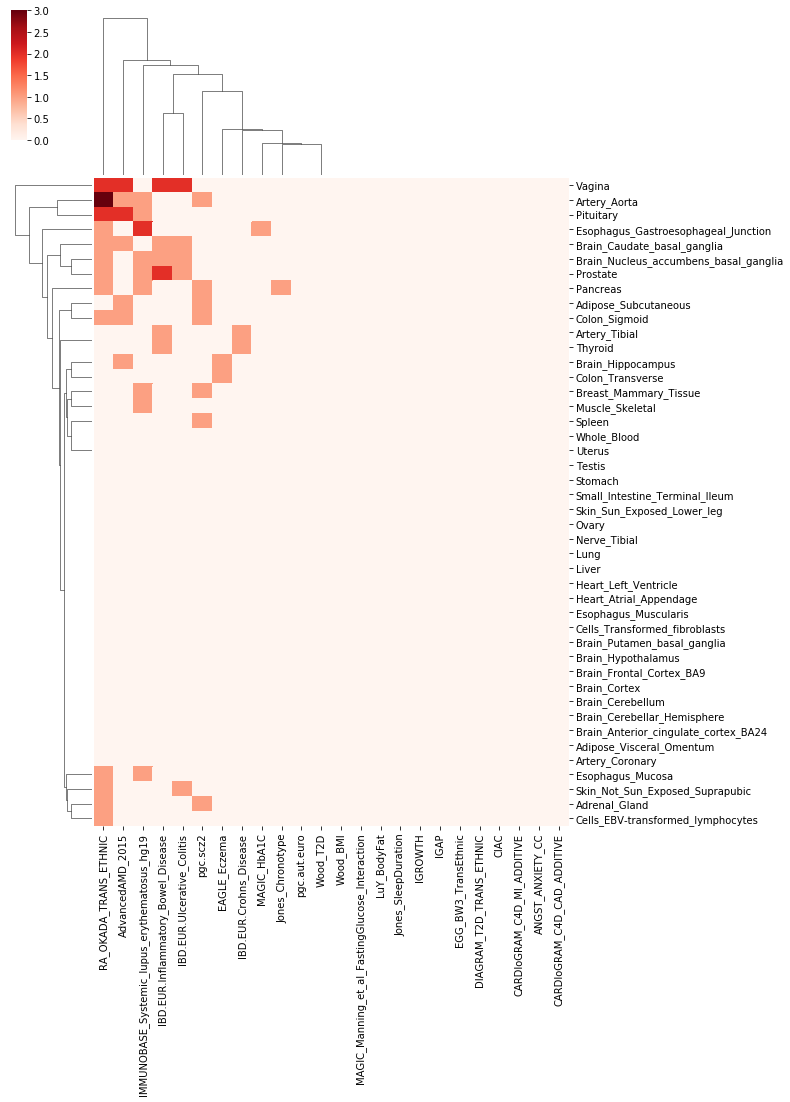

In [15]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.clustermap(pd.DataFrame(count_mat, index=id2ph, columns = id2tissue).T, cmap = 'Reds', figsize = (10, 15))
plt.show()

In [ ]:
for p, c in zip(id2ph, np.sum(np.abs(res_all) > 5.0, axis = 1)):
    print p, c

In [16]:
res_all.keys()

[(u'MAGIC_HbA1C', u'Adipose_Visceral_Omentum'),
 (u'MAGIC_HbA1C', u'Artery_Tibial'),
 (u'IGROWTH', u'Vagina'),
 (u'IMMUNOBASE_Systemic_lupus_erythematosus_hg19',
  u'Brain_Putamen_basal_ganglia'),
 (u'ANGST_ANXIETY_CC', u'Vagina'),
 (u'CIAC', u'Breast_Mammary_Tissue'),
 (u'Jones_Chronotype', u'Colon_Sigmoid'),
 (u'LuY_BodyFat', u'Thyroid'),
 (u'pgc.aut.euro', u'Nerve_Tibial'),
 (u'IBD.EUR.Crohns_Disease', u'Skin_Not_Sun_Exposed_Suprapubic'),
 (u'MAGIC_HbA1C', u'Brain_Hypothalamus'),
 (u'Jones_Chronotype', u'Brain_Putamen_basal_ganglia'),
 (u'DIAGRAM_T2D_TRANS_ETHNIC', u'Brain_Anterior_cingulate_cortex_BA24'),
 (u'IBD.EUR.Inflammatory_Bowel_Disease', u'Whole_Blood'),
 (u'RA_OKADA_TRANS_ETHNIC', u'Brain_Hippocampus'),
 (u'IGROWTH', u'Pituitary'),
 (u'Jones_Chronotype', u'Muscle_Skeletal'),
 (u'AdvancedAMD_2015', u'Esophagus_Gastroesophageal_Junction'),
 (u'EGG_BW3_TransEthnic', u'Esophagus_Mucosa'),
 (u'CARDIoGRAM_C4D_MI_ADDITIVE', u'Brain_Cortex'),
 (u'CARDIoGRAM_C4D_CAD_ADDITIVE', u'Va

In [ ]:
g0 = 'ENSG00000144426'

with h5py.File('../processed_data/model_weights/%s-eigengene_model.h5' % tissue, 'r') as reader:
    id2genes = reader['model_genes'][...]

In [ ]:
[(g, z) for g, z in gene2z.items() if abs(z) > 5.0]

In [ ]:
g0 = 'ENSG00000197375'
model_genes = []

with h5py.File('../processed_data/model_weights/%s-eigengene_model.h5' % tissue, 'r') as reader:
    
    for k in sorted(reader['weights'].keys()):
        pca_genes = reader['weights'][k]['genes'][...]
        pca_weight = reader['weights'][k]['pca_weights'][...]
        pca_sig = reader['weights'][k]['pca_sig'][...]
        
        model_genes += list(pca_genes)
        if g0 in pca_genes:
            print k
            for g in pca_genes:
                if g in gene2z:
                    print gene2z[g]
                else:
                    print g
            break

In [ ]:
[(g, z) for g, z in gene2z.items() if abs(z) > 5.0 and g in model_genes]

In [ ]:
res = []
for k, pca_genes, pca_weight, pca_sig in pca_models:
    if k != 'cluster0932':
        continue
        
    sig_1k = (df_1k[pca_genes].values * pca_weight[np.newaxis, :]).sum(axis = 1).std()
    
    z = compute_gwas_z(pca_genes, pca_weight, sig_1k, gene2z, gene2var)
    res.append(z)

    print k, z, sig_1k
    c = 0.
    for i, g in enumerate(pca_genes):
        if g in gid2gn:
            w, z ,s = pca_weight[i], gene2z[g], gene2var[g]
            print w, z, w*z*np.sqrt(s), np.sqrt(s), np.sqrt(s)/sig_1k
            c += w*z*np.sqrt(s)
    print c / sig_1k, sig_1k

    break

In [ ]:
(df_1k[pca_genes].values * pca_weight[np.newaxis, :]).sum(axis = 1).mean()

In [ ]:
for g in pca_genes:
    if g in gid2gn:
        print gid2gn[g], gene2z[g]


In [ ]:
np.sqrt(pca_weight.dot(df_1k[pca_genes].cov().values).dot(pca_weight))

In [ ]:
c = 0.0
for w, z, s in zip(pca_weight, z_g, sig_g):
    print w, z ,s, w*z*s
    c += w*z*s
print c, c / np.sqrt(pca_weight.dot(df_1k[pca_genes].cov().values).dot(pca_weight))

In [ ]:
z_g = np.zeros(*pca_weight.shape)
sig_g = np.zeros(*pca_weight.shape)

for i, g in enumerate(pca_genes):
    if g in gene2z and g in gene2var:
        z_g[i] = gene2z[g]
        sig_g[i] = np.sqrt(gene2var[g])
            
z_lantent = np.sum(pca_weight * (z_g * sig_g)) / pca_sig

In [ ]:
sig_1k = (df_1k[pca_genes].values * pca_weight[np.newaxis, :]).sum(axis = 1).std()

In [ ]:
np.sum(pca_weight * (z_g * sig_g)) / sig_1k

In [ ]:
sig_1k